**Setup DataSet** & **Load Data**

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
from pathlib import Path
import numpy as np
from typing import Tuple
from read_binvox import read_binvox as rb
import torch
import torch.nn.functional as F


def Setup_Voxel_Classifier_Dataset(rootPath, filetype = "*surface.binvox", pool = 2): # or "*surface.binvox" "*solid.binvox"
    dataset = []
    i = 0
    t = 0
    for class_dir in rootPath.iterdir():
        if class_dir.is_dir():
            label = class_dir.name
            i = 0
            for model_dir in class_dir.iterdir():
                if model_dir.is_dir():
                    models_subdir = model_dir / "models"
                    if models_subdir.exists():
                        for f in models_subdir.glob(filetype):
                            # print("found binvox",f)
                            vol = rb(f)

                            x = torch.tensor(np.asarray(vol), dtype=torch.float32).squeeze(0)

                            #print(x.ndim)
                            if x.ndim == 3:                      # (D,H,W) -> add channel
                                x = x.unsqueeze(0)
                            elif x.ndim == 5:                    # (1,1,D,H,W) -> drop batch
                                x = x.squeeze(0)
                            #print(x.ndim)
                            
                            
                            dataset.append((x,label))
                            i = i + 1
                            #print("model nr:",i)
            print("class :", label)
            if i > 0:
                t += i + 1
                print("Number of model in class :", i,"\n")
    print("Number of Files :", t)
    return dataset


In [3]:
rootPath = Path("../ShapeNetCore")

dataset = Setup_Voxel_Classifier_Dataset(rootPath)

class : Clock
Number of model in class : 651 

class : Computer
Number of model in class : 460 

class : Phone
Number of model in class : 830 

class : Pool
Number of model in class : 856 

class : Television
Number of model in class : 1090 

Number of Files : 3892


Prints out voxel in withmathplot

In [4]:
import torch
import matplotlib.pyplot as plt

def visualize_voxel_grid(vol):
    import numpy as np
    # Accept torch or numpy; accept (1,D,H,W) or (D,H,W)
    if torch.is_tensor(vol):
        vol = vol.detach().to('cpu').numpy()
    vol = np.asarray(vol)
    if vol.ndim == 4:  # (C,D,H,W) or (1,D,H,W)
        vol = vol.squeeze(0)
    assert vol.ndim == 3, f"Expected (D,H,W), got {vol.shape}"

    D,H,W = vol.shape
    # Use ax.voxels for small grids; scatter for large
    if D*H*W <= 40**3:
        fig = plt.figure(figsize=(7,7))
        ax = fig.add_subplot(111, projection='3d')
        ax.voxels(vol > 0, edgecolor='k', linewidth=0.1)
        ax.set_title(f'Voxels ({D}×{H}×{W})')
        plt.show()
    else:
        coords = np.argwhere(vol > 0)  # (Z,Y,X) = (D,H,W)
        if len(coords) > 50_000:
            idx = np.random.choice(len(coords), 50_000, replace=False)
            coords = coords[idx]
        z, y, x = coords[:,0], coords[:,1], coords[:,2]
        fig = plt.figure(figsize=(7,7))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x, y, z, s=1, alpha=0.6)
        try: ax.set_box_aspect((W, H, D))
        except: pass
        ax.set_title(f'Occupied voxels ({D}×{H}×{W})')
        plt.show()


Picked class: Phone 	Tensor shape: (1, 128, 128, 128)


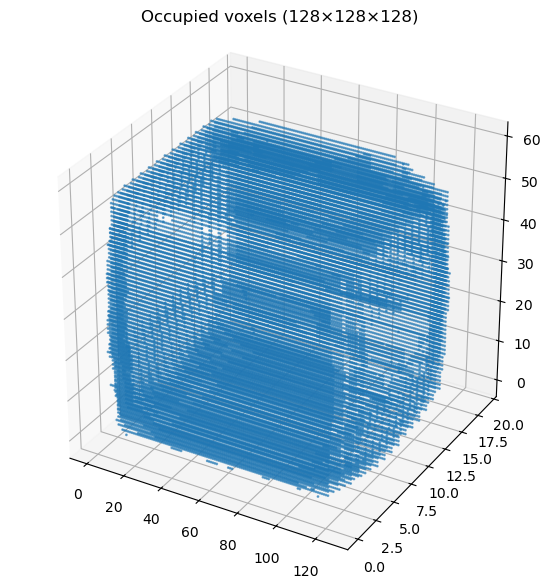

In [ ]:
import random

vox_t, label = random.choice(dataset)   # vox_t: (1, D, H, W) torch.Tensor
print("Picked class:", label, "\tTensor shape:", tuple(vox_t.shape))

visualize_voxel_grid(vox_t)             # the function handles torch 4D


In [ ]:
import torch as t
import torch.nn as nn

class Voxel_CNN_Classifer(nn.Module):
    def __init__(self, num_classes : int):
        super().__init__()
        self.stem = nn.Sequential(
        # (B,1,128,128,128) -> (B,16,64,64,64)
        nn.Conv3d(1,16, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm3d(16),
        nn.ReLU(inplace=True),
        
        # (B,16,64,64,64) -> (B,16,32,32,32)
        nn.MaxPool3d(2),

        # (B,16,32,32,32) -> (B,32,32,32,32)
        nn.Conv3d(16,32,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm3d(32),
        nn.ReLU(inplace=True),
        
        # (B,32,32,32,32) -> (B,32,16,16,16)
        nn.MaxPool3d(2),
        
        # (B,32,16,16,16) -> (B,64,16,16,16)
        nn.Conv3d(32,64,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm3d(64),
        nn.ReLU(inplace=True),

        # (B,64,16,16,16) -> (B,64,8,8,8)
        nn.MaxPool3d(2),

        # (B,64,8,8,8) -> (B,128,8,8,8)
        nn.Conv3d(64,128,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm3d(128),
        nn.ReLU(inplace=True),
        # (B,128,8,8,8) -> (B,128,1,1,1)
        nn.AdaptiveAvgPool3d(1)
        )
        self.head = nn.Linear(128,num_classes)

    def forward(self,x):
        x = self.stem(x)
        x = x.flatten(1)
        return self.head(x)
    

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch, random

#simple wrapper
class ListVoxelDataset(Dataset):
    def __init__(self, pairs, class_to_idx):
        self.pairs = pairs
        self.class_to_idx = class_to_idx
        
    def __len__(self): return len(self.pairs)
    def __getitem__(self,i):
        x, lbl = self.pairs[i]
        y = self.class_to_idx[lbl]
        return x, torch.tensor(y, dtype=torch.long)


In [ ]:
#label mapping
classes = sorted({lbl for _, lbl in dataset})
class_to_idx = {c:i for i,c in enumerate(classes)}
idx_to_class = {i:c for c,i in class_to_idx.items()}
num_classes = len(classes)

In [ ]:
#split
from torch.utils.data import random_split

SEED = 42
train_ratio = 0.8

ids = list(range(len(dataset)))
random.Random(SEED).shuffle(ids)
cut = int(train_ratio * len(ids))
train_pairs = [dataset[i] for i in ids[:cut]]
val_pairs   = [dataset[i] for i in ids[cut:]]

In [ ]:
train_ds = ListVoxelDataset(train_pairs, class_to_idx)
val_ds   = ListVoxelDataset(val_pairs, class_to_idx)

train_loader = DataLoader(train_ds, batch_size=2,shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=2, shuffle=False, num_workers=0, pin_memory=True)
print(f"classes: {classes}")

classes: ['Clock', 'Computer', 'Phone', 'Pool', 'Television']


In [ ]:
x, y = dataset[random.randint(0,3880)]

print(x.shape, y)

torch.Size([1, 128, 128, 128]) Computer


In [ ]:
num_classes = 5
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Voxel_CNN_Classifer(num_classes).to(device)

xb, yb = next(iter(train_loader))      # xb: (B,1,D,H,W)
print("batch:", xb.shape, yb.shape)
with torch.no_grad():
    logits = model(xb.to(device))
print("logits:", logits.shape)         # (B, num_classes)


batch: torch.Size([2, 1, 128, 128, 128]) torch.Size([2])
logits: torch.Size([2, 5])


In [ ]:
criterion = nn.CrossEntropyLoss()

lr = 1e-3
weight_decay = 1e-4
EPOCHS = 7

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

for epoch in range(EPOCHS+1):
    model.train()
    running = 0.0
    for xb, yb in val_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running += loss.item() * xb.size(0)
    train_loss = running / len(train_ds)

    model.eval()
    correct = total = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb).argmax(1)
            correct += (pred == yb).sum().item()
            total += yb.numel()
    val_acc = correct / max(1, total)
    print(f"Epoch {epoch:02d} | train loss {train_loss:.4f} | val acc {val_acc:.3f}")

Epoch 00 | train loss 0.3380 | val acc 0.659
Epoch 01 | train loss 0.2719 | val acc 0.746
Epoch 02 | train loss 0.2223 | val acc 0.743
Epoch 03 | train loss 0.1823 | val acc 0.738
Epoch 04 | train loss 0.1523 | val acc 0.830
Epoch 05 | train loss 0.1264 | val acc 0.838
Epoch 06 | train loss 0.1078 | val acc 0.834
Epoch 07 | train loss 0.0921 | val acc 0.833


In [ ]:
torch.save({"model": model.state_dict(),
            "class_to_idx": class_to_idx},
           "voxel_cnn.pt")